## Sunshine, Stats, and Success: A Tale of the Sunlight Mountain Shop

In Glenwood Springs, nestled near Sunlight Mountain Resort, you'll find Sunlight Mountain Retail. It's a modest shop, but it's the go-to spot for families from Florida, Kansas, Georgia, Ohio, and Michigan. Sunlight's known as one of the most affordable resorts in Colorado, making it a popular choice for budget-conscious travelers.

But Sunlight Mountain Retail isn't just for tourists. It's a hub for church groups, too. Some drive up to 14 hours to reach the slopes, finding everything they need for their snowy adventures at the shop.

Local school groups also make regular visits. They come on weekdays to learn skiing and snowboarding basics, turning the shop into a bustling place where kids gear up for their mountain fun.

Despite its simple appearance, Sunlight Mountain Retail plays a big role in the mountain community. It's where families, church groups, and school kids gear up for their snowy adventures, making memories that'll last a lifetime.

The retail shop offers comforts, like goggles, hand warmers, gloves, socks, that folks may have forgotten or not purchased before venturing up the windy road road to Sunlight. We'll be examining trends in customer purchases at the mountain retail store, focusing on when and what items customers buy.


In [14]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime

from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

print('Libraries Loaded')

Libraries Loaded


Let's load up some sales, vendor, and product data from the mountain retail. 

In [15]:
sales_by_date = '../data/raw/sales/Sales by Year, Month, Day and Hour 20240227 - Sunlight Ski and Bike Shop Resort.csv'
sales_by_hour = '../data/raw/sales/Sales by Hour of Day 20240227 - Sunlight Ski and Bike Shop Resort.csv'
weekday_sales = '../data/raw/sales/Sales by Day of Week 20240227 - Sunlight Ski and Bike Shop Resort.csv'
vendor_sales = '../data/raw/sales/Sales by Vendor 20240227 - Sunlight Ski and Bike Shop Resort.csv'
df2 = pd.read_csv('../data/raw/sales/2021-2022 - Sunlight Ski and Bike Shop.csv', encoding='unicode_escape')
# df.reset_index(inplace=True)
df2.columns.tolist()

['SKU',
 'Description',
 'Category',
 'Vendor',
 'SaleDate',
 'CustomerLocation',
 'Quantity',
 'Total',
 'Month',
 'Day',
 'Year',
 'MSRP',
 'Discount',
 'Sales',
 'Cost',
 'Profit',
 'Margin']

In [16]:
# Step 1: Read the CSV file
df = pd.read_csv('../data/raw/sales/Sales by Year, Month, Day and Hour 20240227 - Sunlight Ski and Bike Shop Resort.csv')

# # Define the starting date
start_date = datetime.datetime.strptime("2020-12-11", "%Y-%m-%d")

# # Create a list of dates with 67682 months (adjust as needed)
date_list = [start_date + datetime.timedelta(days=(30 * i)) for i in range(3147)]

# # Add a new column 'index' with the date list
df['index'] = date_list

# # Set the 'index' column as the index of the DataFrame
df.set_index('index', inplace=True)

# Remove the 'index' name (optional)
df.index.name = None

print(df)

                       Yr       Mth  Dy  Hr  # of Sales   Sales  Avg Sale
2020-12-11 00:00:00  2020  December  11  10           1   35.00     35.00
2021-01-10 00:00:00  2020  December  11  11           2   35.00     17.50
2021-02-09 00:00:00  2020  December  11  12           1   54.99     54.99
2021-03-11 00:00:00  2020  December  11  13           1   47.50     47.50
2021-04-10 00:00:00  2020  December  11  14           4    5.48      1.37
...                   ...       ...  ..  ..         ...     ...       ...
2279-01-08 00:00:00  2024  February   9  13          10  302.22     30.22
2279-02-07 00:00:00  2024  February   9  14           3  155.61     51.87
2279-03-09 00:00:00  2024  February   9  15           8  231.41     28.93
2279-04-08 00:00:00  2024  February   9   8           2  148.49     74.25
2279-05-08 00:00:00  2024  February   9   9           7  724.32    103.47

[3147 rows x 7 columns]


Let's take a peek at when customers purchase the goggles, gloves, and other various items they need to optimize their ski days:

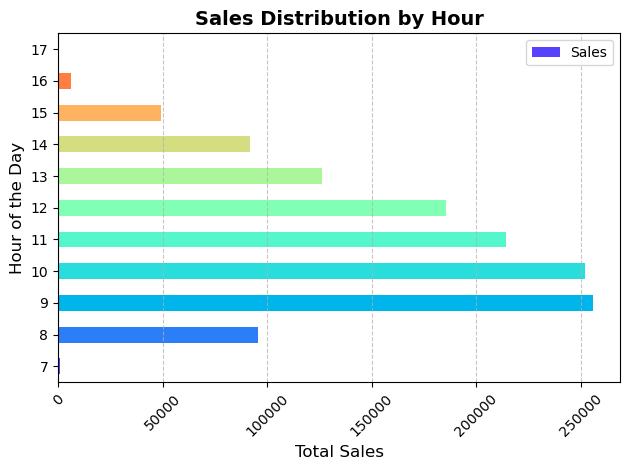

In [17]:
# Load data
hour_sales = pd.read_csv(sales_by_hour)

# Sort hours numerically
hour_sales = hour_sales.sort_values(by='hr')

# Create a rainbow-like color palette
palette = sns.color_palette("rainbow", len(hour_sales))

# Create a horizontal bar chart
ax = hour_sales.plot(kind='barh', x='hr', y='Sales', color=palette, linewidth=1)

# Set labels and title
ax.set_xlabel('Total Sales', fontsize=12)
ax.set_ylabel('Hour of the Day', fontsize=12)
ax.set_title('Sales Distribution by Hour', fontsize=14, fontweight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust spacing
plt.tight_layout()

# Display the chart
plt.show()

It looks like sales are the greatest at 9am and 10am when the mountain has just started running the lift. This certainly makes sense as people have realized what they are missing for the day or what type of conditions are out there so they know what they need to purchase to make it a good experience. 

And as the day goes on, customers come in to buy memorabilia, like logo T-shirts or stickers. 

Let's take a peek at which days these customers are coming in to the store:

In [20]:
# Step 1: Read the CSV file
df = pd.read_csv('../data/raw/sales/Sales by Year, Month, Day and Hour 20240227 - Sunlight Ski and Bike Shop Resort.csv')

# Filter out out-of-bound dates
df = df[df['Yr'] <= 2262]

# Create a datetime column from the Year, Month, Day, and Hour columns
df['datetime'] = pd.to_datetime(df['Yr'].astype(str) + '-' + df['Mth'] + '-' + df['Dy'].astype(str) + ' ' + df['Hr'].astype(str) + ':00:00', errors='coerce')

# Remove rows with invalid dates
df = df.dropna(subset=['datetime'])

# Set the datetime column as the index of the DataFrame
df.set_index('datetime', inplace=True)

# Extract necessary components
df['Hour'] = df.index.hour
df['Day of Week'] = df.index.dayofweek
df['Month'] = df.index.month

# Filter for specific months
df = df[df['Month'].isin([11, 12, 1, 2, 3])]

# Map month numbers to month names
month_map = {1: 'January', 2: 'February', 3: 'March', 11: 'November', 12: 'December'}
df['Month'] = df['Month'].map(month_map)

# Map day of week numbers to day names
day_of_week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Day of Week'] = df['Day of Week'].map(day_of_week_map)

# Aggregate the data
heatmap_data = df.groupby(['Month', 'Day of Week', 'Hour']).size().unstack(level=-1).fillna(0)

# Sort days of the week in the correct order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days, axis=0)

# Create a heatmap for each month
months = heatmap_data.index.levels[0]

for month in months:
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data.loc[month], cmap="YlGnBu", annot=True, fmt=".0f")
    plt.title(f'Heatmap of Sales by Hour and Day of Week for {month}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


AttributeError: 'Index' object has no attribute 'levels'

In [ ]:
day_sales = pd.read_csv(weekday_sales)

# Create a rainbow-like color palette
palette = sns.color_palette("rainbow", len(day_sales))

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(day_sales['Day'], day_sales['Sales'], color=palette)
plt.xlabel('Total Sales')
plt.ylabel('Day of the Week')
plt.title('Sales by Day of the Week')
plt.show()

No suprise that Friday, Saturday and Sunday are the heaviest days of sales. Those weekdays are the busiest days on the mountain as well. Are you as shocked as I am that Mondays are not far behind Fridays in terms of sales? That might be because most holidays in the winter fall on Mondays, like MLK day and President's weekend.

Now, let's take a peek at the seasonal trends. We have four winter's worth of data at the store (as that is when this new point of sales system was put into place). And interestingly, this sales data takes into account COVID winter when the resorts shut down and the snowy winter of 2022-2023. 

In [ ]:

# Step 2: Rearrange date components and convert to datetime
df['Datetime'] = pd.to_datetime(df[['Yr', 'Mth', 'Dy', 'Hr']].astype(str).agg('-'.join, axis=1))

# Step 3: Group by datetime and aggregate sales data
grouped_data = df.groupby('Datetime').agg({'# of Sales': 'sum', 'Sales': 'sum', 'Avg Sale': 'mean'}).reset_index()

# Step 4: Plot the timeline chart
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['Datetime'], grouped_data['Sales'], label='Total Sales', marker='s', linewidth=1)
plt.plot(grouped_data['Datetime'], grouped_data['Avg Sale'], label='Average Sale', marker='^', linewidth=1)

plt.xlabel('Date and Time')
plt.ylabel('Sales')
plt.title('Sales Timeline')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This shows the seasonality of purchases in the retail store at Sunlight mountain. The winter season starts around October/November until April, when the mountain is open. The opening data varies on the snow year. 

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(grouped_data['Avg Sale'], period=360)

# Define colors for each plot
colors = ['blue', 'green', 'red', 'purple']  # Add more colors as needed

# Plot the trend, seasonal, and residual components with different colors
fig, axes = plt.subplots(4, 1, figsize=(15, 8))
axes[0].plot(decomposition.trend, color=colors[0])
axes[0].set_title('Trend')
axes[1].plot(decomposition.seasonal, color=colors[1])
axes[1].set_title('Seasonal')
axes[2].plot(decomposition.resid, color=colors[2])
axes[2].set_title('Residual')
axes[3].plot(decomposition.observed, color=colors[3])
axes[3].set_title('Observed')
plt.tight_layout()
plt.show()

The top panel shows the trend component, which represents the overall long-term trajectory or movement of the data. The smooth, curved line indicates a gradual upward trend over time, suggesting an increasing pattern in sales transactions.

The second panel displays the seasonal component, which captures the recurring patterns or fluctuations within each cycle (e.g., weekly, monthly, or yearly). The regular, wave-like green bars indicate a strong seasonal influence on sales transactions, potentially due to factors like holidays, promotions, or consumer behavior patterns.

The third panel represents the residual component, which shows the remaining variations in the data after accounting for the trend and seasonal components. The red spikes and dips suggest that there are still some unexplained fluctuations or irregularities in the sales transactions that cannot be attributed to the trend or seasonal patterns.

The bottom panel shows the observed data, which is the combination of the trend, seasonal, and residual components. The purple spikes represent the actual sales transactions over time, capturing the overall pattern, including the trend, seasonal variations, and residual irregularities.

In summary, this decomposition plot suggests that the sales transactions exhibit:

An overall increasing trend over time.
Significant seasonal patterns or cycles that repeat regularly (e.g., monthly, quarterly, or annually).
Residual variations or irregularities that cannot be explained by the trend or seasonal components alone, potentially due to factors like promotions, external events, or random fluctuations.

In [ ]:
# Group the data by date and sum the 'Sales' column
sales_by_date = df.groupby('Datetime')['Sales'].sum().reset_index()

# Group the data by date and sum the 'Sales' column
sales_by_date = sales_by_date.groupby('Datetime')['Sales'].sum().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['Datetime'], sales_by_date['Sales'])
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend Over Time')
plt.xticks(rotation=45)
plt.show()

Let's zoom in a little bit to see why the sales was so much greater in 2021. Maybe onr thing we can look at is historical weather for that winter. 

In [ ]:
# Assuming 'Datetime' column is already in datetime format
# Filter the data for the period from October 2021 to April 2022
sales_oct_2020_to_apr_2021 = sales_by_date[((sales_by_date['Datetime'].dt.year == 2020) & (sales_by_date['Datetime'].dt.month >= 10)) | ((sales_by_date['Datetime'].dt.year == 2021) & (sales_by_date['Datetime'].dt.month <= 4))]

# Create a line plot for the period from October 2021 to April 2022 data
plt.figure(figsize=(12, 6))
plt.plot(sales_oct_2020_to_apr_2021['Datetime'], sales_oct_2020_to_apr_2021['Sales'])
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend For Winter 2020/2021 :: The winter of COVID')

# Set x-axis major locator and formatter to display month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'Datetime' column is already in datetime format
# Filter the data for the period from October 2021 to April 2022
sales_oct_2021_to_apr_2022 = sales_by_date[((sales_by_date['Datetime'].dt.year == 2021) & (sales_by_date['Datetime'].dt.month >= 10)) | ((sales_by_date['Datetime'].dt.year == 2022) & (sales_by_date['Datetime'].dt.month <= 4))]

# Create a line plot for the period from October 2021 to April 2022 data
plt.figure(figsize=(12, 6))
plt.plot(sales_oct_2021_to_apr_2022['Datetime'], sales_oct_2021_to_apr_2022['Sales'],color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend For Winter 2021/2022 :: Two Years Post COVID')

# Set x-axis major locator and formatter to display month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'Datetime' column is already in datetime format
# Filter the data for the period from October 2021 to April 2022
sales_oct_2022_to_apr_2023 = sales_by_date[((sales_by_date['Datetime'].dt.year == 2022) & (sales_by_date['Datetime'].dt.month >= 10)) | ((sales_by_date['Datetime'].dt.year == 2023) & (sales_by_date['Datetime'].dt.month <= 4))]

# Create a line plot for the period from October 2021 to April 2022 data
plt.figure(figsize=(12, 6))
plt.plot(sales_oct_2022_to_apr_2023['Datetime'], sales_oct_2022_to_apr_2023['Sales'],color='salmon')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend For Winter 2022/2023')

# Set x-axis major locator and formatter to display month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'Datetime' column is already in datetime format
# Filter the data for the period from October 2021 to April 2022
sales_oct_2023_to_apr_2024 = sales_by_date[((sales_by_date['Datetime'].dt.year == 2023) & (sales_by_date['Datetime'].dt.month >= 10)) | ((sales_by_date['Datetime'].dt.year == 2024) & (sales_by_date['Datetime'].dt.month <= 4))]

# Create a line plot for the period from October 2021 to April 2022 data
plt.figure(figsize=(12, 6))
plt.plot(sales_oct_2023_to_apr_2024['Datetime'], sales_oct_2023_to_apr_2024['Sales'],color='purple')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend For Winter 2023/2024')

# Set x-axis major locator and formatter to display month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Another consideration besides COVID impact is the winter weather for the year. Typically, more snow brings in more local skiers and boarders. It looks like 2022-2023 was a record snow year. And 2021-2022 was typical. 

| Monthly/Annual | Total Snowfall | Snowfall Days | Average Base Depth | Average Summit Depth | Max Base Depth | Biggest Snowfall |
|-----------------|-----------------|----------------|--------------------|-----------------------|-----------------|-------------------|
| 2019 - 2020     | 105"            | 41 Day         | 24"                | 35"                   | 35             | 9"                |
| 2020 - 2021     | 81"             | 26 Day         | 25"                | 28"                   | 46             | 7"                |
| 2021 - 2022     | 182"            | 39 Day         | 38"                | 43"                   | 51             | 13"               |
| 2022 - 2023     | 206"            | 56 Day         | 38"                | 46"                   | 80             | 13"               |
| 2023 - To Date | 100"            | 30 Day         | 27"                | 31"                   | 44             | 10"               |
| Average         | 142"            | 42 Day         | 42"                | 39"                   | 64             | 1"                |


In [ ]:
# Removed Sunlight Bike and Ski,24035,666375.53
# Load data
vendor_sales = pd.read_csv('../data/raw/sales/Sales by Vendor 20240227 - Sunlight Ski and Bike Shop Resort.csv')

# Remove vendors with 5 or fewer products
vendor_sales = vendor_sales[vendor_sales['Units Sold'] > 5]

# Sort vendors alphabetically
vendor_sales = vendor_sales.sort_values(by='Sales Total')

# Define colors for each bar
colors = sns.color_palette("tab10")

# Create a bar plot with sorted vendors and colored bars
plt.figure(figsize=(12, 6))
plt.bar(vendor_sales['Name'], vendor_sales['Sales Total'], color=colors[:len(vendor_sales)])
plt.xlabel('Vendor')
plt.ylabel('Total Sales')
plt.title('Sales by Vendor')
plt.xticks(rotation=90)
plt.show()


The leading vendor is "Smith Optics". The primary product we sell from Smith is goggles. Customers walk in during the morning of their ski day-- all ready, excited to get on the mountain and they realize that they (1) forgot their goggles at home (2) live in a warm area and don't own goggles or (3) realize that their lens are not working for the conditions of the day or their current goggle is fogging up and making it hard to see. 

Gear for Sports is the Sunlight logoes T-shirt provider. T-Shirts are popular items for out-of-towners to take back home to their warm environments in the cold winter or when spring time approaches. It is a little taste of Sunlight that that can bring back home. 

Seirus is the glove and buff seller. These are the items that people buy when it is colder than they aniticipated. 

Locale is out sock and beanie provider. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    fig = plt.figure(figsize=(12, 8))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Example usage:
# Assuming 'grouped_data' is a DataFrame with 'Avg Sale' column representing the time series
test_stationarity(grouped_data['Avg Sale'])


This chart displays a rolling mean and rolling standard deviation calculated over a time series data, along with the original data points.

The blue line represents the original data values over time. The red line shows the rolling mean, which is a smoothed average of the data calculated over a specific window size (e.g., 7-day, 30-day, or other time periods). The rolling mean helps to identify the underlying trend or central tendency in the data by reducing the impact of individual fluctuations.

The green line represents the rolling standard deviation, which measures the amount of variability or spread around the rolling mean over the same window size. Higher values of the rolling standard deviation indicate greater volatility or dispersion in the data during that period, while lower values suggest more stability or consistency.

The combination of the rolling mean and rolling standard deviation provides insights into the overall behavior and volatility patterns of the time series data. The rolling mean helps to smooth out the noise and reveal the general trend, while the rolling standard deviation quantifies the degree of fluctuation or risk around that trend.

This type of chart is useful for analyzing and understanding the dynamics of time series data, such as stock prices, sales figures, sensor readings, or any other data that varies over time. It can help identify periods of stability or volatility, detect potential anomalies or outliers, and support decision-making processes that depend on understanding the underlying patterns and risks in the data.

## Summary

The observations provide a comprehensive overview of sales trends and customer behavior at Sunlight Mountain Retail, situated near Sunlight Mountain Resort in Glenwood Springs, Colorado. Here's a summary of the key points highlighted:

1. **Customer Demographics and Activities**:
   - Sunlight Mountain Retail caters not only to tourists but also serves as a hub for church groups and local school outings, reflecting its significance in the mountain community.
   - Families, church groups, and school kids visit the shop to gear up for their snowy adventures, indicating a diverse customer base.

2. **Sales Distribution by Hour**:
   - Sales peak at 9 am and 10 am when the mountain lift operations commence, suggesting customers purchase essential items just before hitting the slopes.
   - Later in the day, customers buy memorabilia like logo T-shirts or stickers, indicating a shift in purchasing behavior towards souvenirs as the day progresses.

3. **Sales Distribution by Day of the Week**:
   - Fridays, Saturdays, and Sundays witness the highest sales, consistent with the busiest days on the mountain.
   - Surprisingly, Mondays also see significant sales, possibly due to holidays falling on Mondays during the winter season.

4. **Seasonal Trends in Sales**:
   - Seasonal decomposition analysis reveals an increasing trend in sales over time, with significant seasonal fluctuations and residual variations.
   - Sales exhibit a cyclical pattern, with peaks during the winter months when the mountain is open for skiing and snowboarding.

5. **Impact of External Factors**:
   - Analysis of winter sales trends suggests that factors like COVID-19 restrictions and weather conditions influence sales patterns.
   - Record snowfall years, such as 2022-2023, coincide with higher sales, indicating a correlation between snow conditions and customer traffic.

6. **Vendor Contribution to Sales**:
   - Leading vendors like Smith Optics, Gear for Sports, Seirus, and Locale play vital roles in offering essential products like goggles, T-shirts, gloves, socks, and beanies.
   - Sales by vendors reflect customer preferences for specific product categories and brands.

7. **Stationarity Test**:
   - The stationarity test helps assess the stability and consistency of sales data over time, providing insights into underlying trends and fluctuations.

Overall, the observations underscore the dynamic nature of sales trends at Sunlight Mountain Retail, influenced by various factors such as customer demographics, seasonal variations, external conditions, and product offerings. Understanding these dynamics is crucial for optimizing inventory management, marketing strategies, and overall business performance in the mountain retail industry.
